# 使用Cifar10練習影像分類，模型設計調校

In [1]:
#匯入函式庫，數值矩陣計算numpy，以及畫圖用的matplotlib
import numpy as np
import matplotlib.pyplot as plt

#匯入
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [2]:
#匯入tensorflow的函式庫，以及cifar10
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

In [3]:
#註：呼叫這些功能的寫法有兩種，以cifar10為例
#一、直接打一整串：tf.keras.datasets.cifar10.load_data()
#二、在一開始的地方使用from tensorflow.keras.datasets import cifar10，以後只要用cifar10.load_data()即可

## 讀取與檢視資料

In [4]:
#使用cifar10的資料集
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [5]:
X_train.shape

(50000, 32, 32, 3)

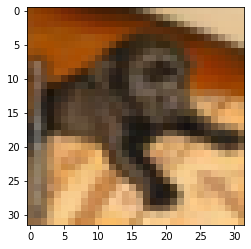

In [6]:
plt.imshow(X_train[56])

In [7]:
# 0 : airplain (飛機)
# 1 : automobile (汽車)
# 2 : bird (鳥)
# 3 : cat (貓)
# 4 : deer (鹿)
# 5 : dog (狗)
# 6 : frog (青蛙)
# 7 : horse (馬)
# 8 : ship (船)
# 9 : truck (卡車)

## 影像前處理

In [8]:
#對影像作正規化
x_train = X_train.astype('float32')/255
x_test = X_test.astype('float32')/255

In [9]:
#對類別資料作One-hot encoding
y_train = tf.keras.utils.to_categorical(Y_train)
y_test = tf.keras.utils.to_categorical(Y_test)

## 建立AI模型

In [10]:
#撰寫模型
input_layer=tf.keras.layers.Input(shape=(32,32,3))

x=tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(input_layer)
x=tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
x=tf.keras.layers.MaxPool2D()(x)

x=tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x)
x=tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x)
x=tf.keras.layers.MaxPool2D()(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(64, activation='relu')(x)
x=tf.keras.layers.Dropout(0.5)(x)

output_layer=tf.keras.layers.Dense(10, activation='softmax')(x)

In [11]:
model=tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0     

In [12]:
#data augmentation相關設定
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)  

## 開始訓練

In [13]:
#告訴AI學習的方式
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])


In [14]:
#將訓練的模型置放於model_path下的model_name
model_name = 'cirfar10'

save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
model_path = os.path.join(save_dir, model_name)

In [15]:
#設定模型存放方式(只存Validation表現最好的那一次)
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, monitor = 'val_loss', save_best_only = True, verbose = 1)

#設定多久沒進步就停下來
earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, verbose = 1)

In [16]:
#開始訓練，順便把訓練過程存到model_history，方便後續畫圖
model_history=model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=70, 
                        steps_per_epoch=len(x_train)/32, validation_data=(x_test,y_test), callbacks=[earlystop, checkpoint])

Epoch 1/70
1562/1562 [==============================] - 21s 12ms/step - loss: 1.8222 - categorical_accuracy: 0.3192 - val_loss: 1.4090 - val_categorical_accuracy: 0.4954

Epoch 00001: val_loss improved from inf to 1.40903, saving model to /home/h282475249/image_classification/saved_models/cirfar10
INFO:tensorflow:Assets written to: /home/h282475249/image_classification/saved_models/cirfar10/assets
Epoch 2/70
1562/1562 [==============================] - 17s 11ms/step - loss: 1.4993 - categorical_accuracy: 0.4559 - val_loss: 1.2183 - val_categorical_accuracy: 0.5597

Epoch 00002: val_loss improved from 1.40903 to 1.21830, saving model to /home/h282475249/image_classification/saved_models/cirfar10
INFO:tensorflow:Assets written to: /home/h282475249/image_classification/saved_models/cirfar10/assets
Epoch 3/70
1562/1562 [==============================] - 18s 12ms/step - loss: 1.3728 - categorical_accuracy: 0.5072 - val_loss: 1.1671 - val_categorical_accuracy: 0.5779

Epoch 00003: val_loss i

## 畫圖

In [26]:
model_history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

In [27]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

training_acc = model_history.history['categorical_accuracy']
val_acc = model_history.history['val_categorical_accuracy']

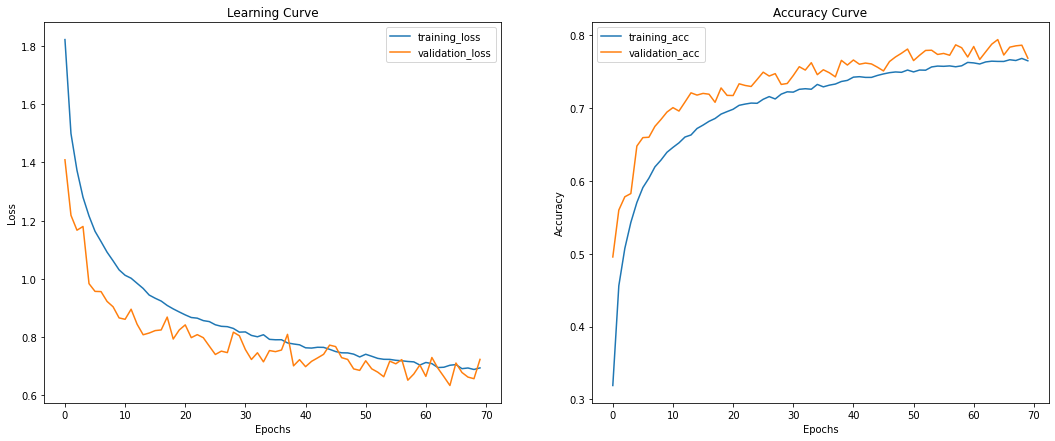

In [28]:
#畫圖
plt.figure(figsize=(18, 7))
plt.subplot(121)
plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')

plt.subplot(122)
plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.legend(loc='upper left')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend(loc='best')

plt.show()

## 作預測

In [29]:
#載入訓練好的模型
model = tf.keras.models.load_model(model_path)

In [30]:
#使用AI模型作預測
pred=model.predict(x_test)

In [31]:
#將預測的機率轉換成類別
ans=np.argmax(pred, axis=-1)

In [32]:
#畫出混淆矩陣
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(Y_test, ans)
print(cf_matrix)

[[840  16  43  11  10   1  11   7  31  30]
 [  3 935   1   3   0   2   6   1  11  38]
 [ 61   2 651  48  42  64  96  19   7  10]
 [ 17   6  37 551  25 212  98  21   9  24]
 [ 13   0  55  49 706  24  86  59   3   5]
 [  9   2  28  88  27 766  33  33   3  11]
 [  6   2  21  31   2  12 913   4   4   5]
 [ 13   1  27  32  28  54  15 817   2  11]
 [ 67  28   7   6   1   1   4   2 854  30]
 [ 19  51   7   2   1   2   3   2  12 901]]


<AxesSubplot:>

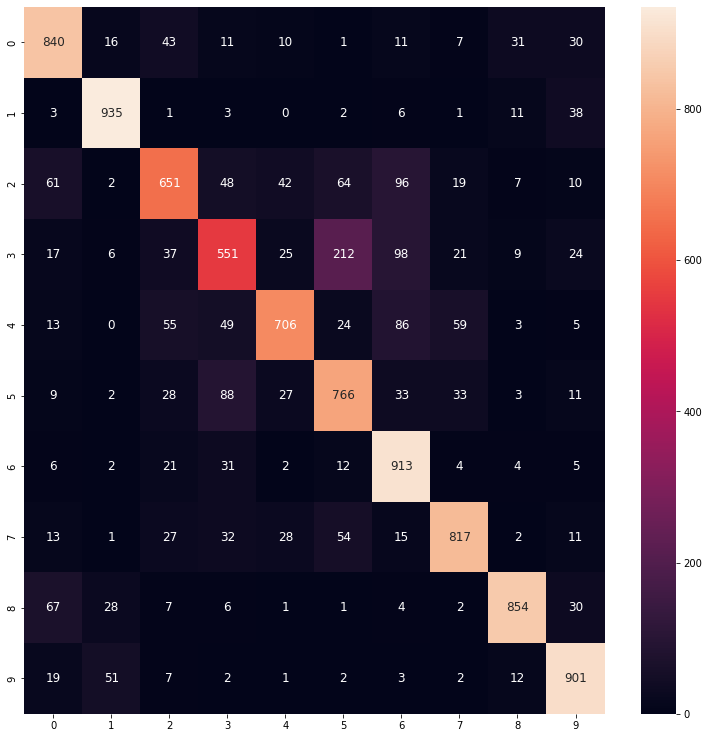

In [33]:
#對混淆矩陣畫圖
import seaborn as sns
fig, ax = plt.subplots(figsize=(13,13))
sns.heatmap(cf_matrix, fmt='g', annot=True, annot_kws={"size":12})

In [34]:
#計算統計指標
from sklearn.metrics import classification_report
report = classification_report(Y_test, ans)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1000
           1       0.90      0.94      0.92      1000
           2       0.74      0.65      0.69      1000
           3       0.67      0.55      0.61      1000
           4       0.84      0.71      0.77      1000
           5       0.67      0.77      0.72      1000
           6       0.72      0.91      0.81      1000
           7       0.85      0.82      0.83      1000
           8       0.91      0.85      0.88      1000
           9       0.85      0.90      0.87      1000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000

